# This script is meant to check easily if the energy difference and energy function is implemented correctly

In [1]:
@everywhere using Distributions
@everywhere using Base.Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
using MCMCDiagnostics
@everywhere src_path = "../Source/"
@everywhere include(src_path*"types.jl")
@everywhere include(src_path*"functions_msc.jl")
@everywhere include(src_path*"functions_neighbors.jl")
@everywhere include(src_path*"functions_types.jl")
@everywhere include(src_path*"functions_energy.jl")
@everywhere include(src_path*"functions_mc.jl")
@everywhere include(src_path*"functions_thermalization.jl")
@everywhere include(src_path*"functions_observables.jl")
@everywhere include(src_path*"functions_symmetries.jl")
include(src_path*"functions_plots_and_files.jl")
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
# System to test on

THERM_FRAC = 1/10
DT_MAX = 10000
MEASURE_FILE = "measured.statelist"

@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 1.0    # Gauge coupling
ν = 0.3    # Anisotropy

# Other parameters
L = 12     # System length
L₃ = 12
N = L^2*L₃
T_list = [0.1, 0.1, 1.3] #[T for T = 0.1:0.4:1.5]
κ₅ = 1.0

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = 0.0/L
println("f set to $(f)")
sim = Controls(π-π/12, 1.0, 4.0)

syst_list = [SystConstants(L, L₃, 1/g^2, ν, κ₅, f, 1/T_list[i]) for i = 1:length(T_list)]
ψ_list = [State(5, copy(syst); u⁺=1.0, u⁻=0.0) for syst in syst_list]
sim_list = [copy(sim) for i = 1:length(T_list)];

f set to 0.0


In [3]:
println("\nTesting Energy difference function ΔE\n----------------------------------------------------------------")
# Test case. We take the first state described above and put two different lattice sites in the middle
# i.e. the [2,2] position. Then we use the different functions to calculate the energy
# difference associated with this change.

L = 5
ψ₂ = ψ_list[1]
ϕ′ = LatticeSite() # Get random lattice site
ψ₁ = copy(ψ₂) # This state will be modified
@test ψ₁.nb[3,2,2].ϕᵣ₊₂.u⁺ == ψ₁.lattice[2,2,2].u⁺
@test ψ₁.nb[3,2,2].ϕᵣ₊₂ == ψ₁.lattice[2,2,2]
set!(ψ₁.lattice[2,2,2], ϕ′)
@test ψ₁.nb[3,2,2].ϕᵣ₊₂.u⁺ == ϕ′.u⁺

dE = ΔE(ϕ′,ψ₂.lattice[2,2,2],ψ₂.nb[2,2,2],ψ₂.nnb[2,2,2],ψ₂.nnnb[2,2,2], 2,ψ₂.consts)
println("Checking that ΔE and E get same result")
println(@test testEnDiff(ψ₂, ψ₁, dE))
#println(@test isapprox(E(ψ₁)-E(ψ₂), dE; atol=0, rtol=1e-13))



Testing Energy difference function ΔE
----------------------------------------------------------------
Checking that ΔE and E get same result
Test Passed


In [5]:
ψ₀ = ψ_list[1]
println("Checking that ΔE gives same result as E'-E on all different sites of the lattice")
ψ = copy(ψ₀)
for z_pos = 1:L, h_pos = 1:L, v_pos = 1:L
    ψ = copy(ψ₀)
    ϕ′ = LatticeSite()
    dE = ΔE(ϕ′, ψ₀.lattice[v_pos,h_pos,z_pos],ψ₀.nb[v_pos,h_pos,z_pos],ψ₀.nnb[v_pos,h_pos,z_pos],ψ₀.nnnb[v_pos,h_pos,z_pos],h_pos,ψ₀.consts)
    set!(ψ.lattice[v_pos,h_pos,z_pos], ϕ′)
    if !testEnDiff(ψ₀, ψ, dE)
        println("[$(v_pos), $(h_pos), $(z_pos)]")
    end
    #@test isapprox(E(ψ₁)-E(ψ₂), dE; atol=0, rtol=1e-13)
end
println(@test isapprox(E(ψ)-dE, E(ψ₀); atol=0, rtol=1e-13))



Checking that ΔE gives same result as E'-E on all different sites of the lattice
|(E′-E₀)-dE|/max(E′-E₀, dE) = 1.3820758296604226e-14
E₀			ΔE			E′-E₀			|ΔE-E₁-E₂|
-6.646314080376028	6.490672831732649	6.490672831732559	8.970602038971265e-14
[3, 1, 1]
|(E′-E₀)-dE|/max(E′-E₀, dE) = 1.3034070402633699e-14
E₀			ΔE			E′-E₀			|ΔE-E₁-E₂|
-6.646314080376028	6.337283019080605	6.337283019080522	8.260059303211165e-14
[4, 2, 3]
|(E′-E₀)-dE|/max(E′-E₀, dE) = 1.174084399425475e-14
E₀			ΔE			E′-E₀			|ΔE-E₁-E₂|
-6.646314080376028	6.127536660134005	6.127536660133933	7.194245199571014e-14
[1, 1, 4]
|(E′-E₀)-dE|/max(E′-E₀, dE) = 1.0999511015527875e-14
E₀			ΔE			E′-E₀			|ΔE-E₁-E₂|
-6.646314080376028	6.621260737190604	6.621260737190531	7.283063041541027e-14
[1, 3, 4]
|(E′-E₀)-dE|/max(E′-E₀, dE) = 1.073668303391153e-14
E₀			ΔE			E′-E₀			|ΔE-E₁-E₂|
-6.646314080376028	6.369726860791406	6.369726860791338	6.838973831690964e-14
[2, 5, 4]
|(E′-E₀)-dE|/max(E′-E₀, dE) = 1.1993657634402838e-14
E₀			ΔE			E′-E₀			|ΔE-E

## Let's run the highest temperature for a while and see what we get

Test Passed
4524.014236120103
4524.014236120107


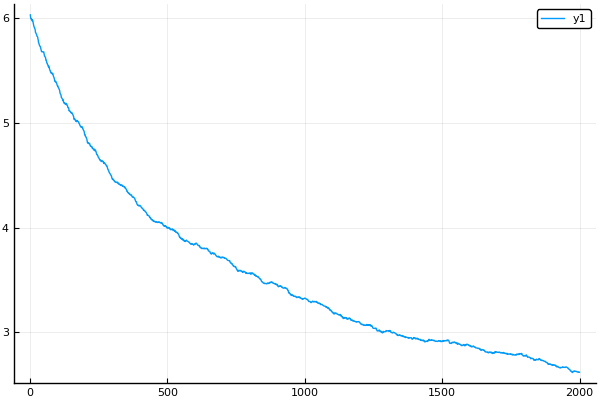

In [3]:
M = 2000
ψ₀ = copy(ψ_list[end])
ψ = copy(ψ_list[end])
sim = copy(sim_list[end])
ψ, E_list = nMCSEnergy(ψ, sim, M, E(ψ))
dE = E_list[end] - E(ψ₀)
println(@test testEnDiff(ψ₀, ψ, dE))
println(E_list[end])
println(E(ψ))
plot(E_list./L^3)

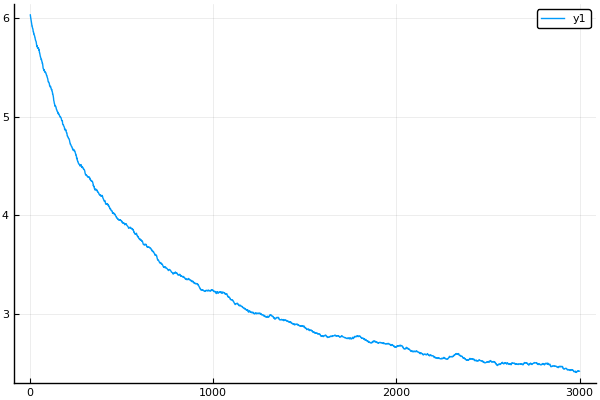

6.045329314067735
2.4178007819752905


In [4]:
M = 3000
ψ = ψ_list[end]
sim = copy(sim_list[end])
println(E(ψ)/L^3)
_, E_list = nMCSEnergy(ψ, sim, M, E(ψ))
display(plot(E_list./L^3))
println(E(ψ)/L^3)

In [160]:
println(E(ψ)/L^3)
for i = 1:M
    mcSweep!(ψ, sim)
end
println(E(ψ)/L^3)

5.881850642269211
6.135455396872984


In [161]:
test = copy(ψ)
for i = 1:M
    mcSweep!(test, sim)
end
println(E(test)/L^3)

2.582921756276382


In [164]:
test = copy(ψ)
for i = 1:1000
    pos = [rand(1:L), rand(1:L), rand(1:L₃)]
    er =  metropolisHastingUpdate!(test, pos, sim)
    if er != 0.0
        println("$(er)  \t\t$(pos)")
    end
end

-3.617435497737944  		[6, 6, 1]
-0.6320555733610558  		[10, 9, 4]
-3.2797750342418563  		[12, 6, 5]
0.6034374614967097  		[5, 10, 8]
-1.453885382487563  		[5, 10, 3]
-0.6003966165197498  		[8, 5, 4]
-0.203387683061111  		[8, 7, 12]
3.1856249637528187  		[8, 4, 3]
-4.0767773112276  		[1, 1, 11]
-0.23192774584913756  		[12, 7, 6]
0.4235039411855316  		[2, 6, 3]


In [156]:
println(ψ.consts)

SystConstants(12, 12, 1.0, 0.3, 1.0, 0.0, 0.7692307692307692)


In [165]:
ψ₀ = copy(ψ)
for i = 1:1000
    pos = [rand(1:L), rand(1:L), rand(1:L₃)]
    er =  metropolisHastingUpdate!(ψ, pos, sim)
    if er != 0.0
        println("$(er)  \t\t$(pos)")
    end
end    

-2.529532630388437  		[1, 9, 5]
-3.046619397323189  		[2, 2, 12]
-1.1854618383575395  		[3, 10, 3]
-0.6422104076789097  		[4, 10, 7]
-1.1758033303247082  		[4, 9, 9]
0.2783946662513621  		[12, 12, 7]
-4.62022481279258  		[1, 10, 6]


In [177]:
pos = [3, 4, 2]
@show ψ₀.lattice[pos...]
@show ψ.lattice[pos...]

ψ₀.lattice[pos...] = LatticeSite([-83.5312, 20.0208, 19.5765], 4.258410988429313, 2.493961084527919, 1.0, 0.0)
ψ.lattice[pos...] = LatticeSite([-84.0016, 20.9253, 18.6687], 4.258410988429313, 2.493961084527919, 1.0, 0.0)


LatticeSite([-84.0016, 20.9253, 18.6687], 4.258410988429313, 2.493961084527919, 1.0, 0.0)

In [13]:
@show E(ψ)/L^3

E(ψ) / L ^ 3 = 5.907818531804236


5.907818531804236

In [23]:
M = 3000
ψ = ψ_list[end]
sim = copy(sim_list[end])
@show E(ψ)/L^3
ψ = nMCS(ψ, sim, M)
@show E(ψ)/L^3

E(ψ) / L ^ 3 = 5.91609936943902
E(ψ) / L ^ 3 = 6.124456676670158


6.124456676670158

In [13]:
ar, mcs, ψ, sim = adjustSimConstants!(sim, ψ, 100);

(0.3069618055555555, 9600, State(LatticeSite[LatticeSite([-4.45255, 12.0305, 16.3219], 3.01684, 1.41816, 1.0, 0.0) LatticeSite([7.74141, 0.201025, 5.66417], 5.03569, 0.301127, 1.0, 0.0) … LatticeSite([-6.46364, -5.61038, 13.5457], 5.98154, 1.93797, 1.0, 0.0) LatticeSite([10.1801, 19.7373, 15.8829], 5.73177, 5.74286, 1.0, 0.0); LatticeSite([4.48843, -4.02815, 1.66918], 1.34297, 1.97143, 1.0, 0.0) LatticeSite([-10.9346, -13.2749, -10.2619], 6.16772, 4.1499, 1.0, 0.0) … LatticeSite([-5.22778, -10.7102, -6.70087], 4.22335, 2.37602, 1.0, 0.0) LatticeSite([2.15463, -11.1967, -5.91781], 4.52244, 4.99382, 1.0, 0.0); … ; LatticeSite([6.58142, 0.591619, 8.52512], 5.48978, 2.62618, 1.0, 0.0) LatticeSite([-7.1822, -4.1934, 2.63733], 5.89591, 1.42069, 1.0, 0.0) … LatticeSite([1.50124, 0.440365, 6.48113], 0.42426, 3.95412, 1.0, 0.0) LatticeSite([-2.73707, 0.78097, 1.9407], 1.76659, 3.54532, 1.0, 0.0); LatticeSite([-15.0208, -9.65119, -4.1989], 2.13509, 1.82664, 1.0, 0.0) LatticeSite([1.9265, 12.1745

true
3597.560934057982
3597.560934057977


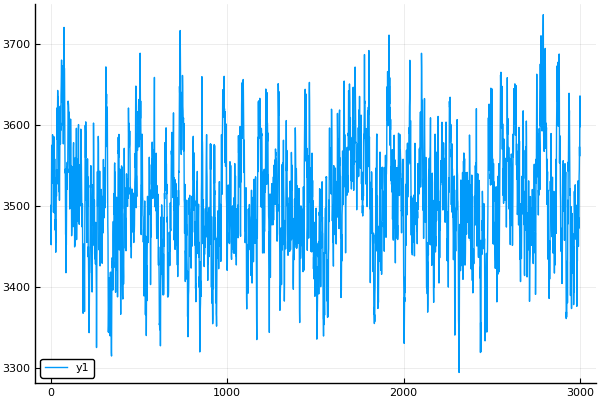

In [16]:
ψ₀ = copy(ψ)
ψ, E_list = nMCSEnergy(ψ, sim, M, E(ψ))
dE = E_list[end] - E(ψ₀)
println(testEnDiff(ψ₀, ψ, dE))
println(E_list[end])
println(E(ψ))
plot(E_list)

## If everything looks good so far we can run all the temperatures.

In [6]:
for i = 1:length(ψ_list)
    println(ψ_list[i].consts)
    println(1/ψ_list[i].consts.β)
end

SystConstants(12, 12, 1.0, 0.3, 1.0, 0.0, 10.0)
0.1
SystConstants(12, 12, 1.0, 0.3, 1.0, 0.0, 10.0)
0.1
SystConstants(12, 12, 1.0, 0.3, 1.0, 0.0, 0.7692307692307692)
1.3


In [7]:
[ψ_list[1].lattice[v,h,3].θ⁺ for v = 1:L, h = 1:L]

12×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[E(test_ψ_list[i]) for i = 1:length(test_ψ_list)] = [10437.6, 10424.7, 10548.9]
 52.305167 seconds (125.01 M allocations: 4.494 GiB, 2.95% gc time)
[E(test_ψ_list[i]) for i = 1:length(test_ψ_list)] = [2383.2, 2757.87, 3624.2]
[E_matrix[s, end] for s = 1:size(E_matrix, 1)] = [2383.2, 2757.87, 3624.2]
[E(ψ) for ψ = ψ_list] = [10437.6, 10424.7, 10548.9]


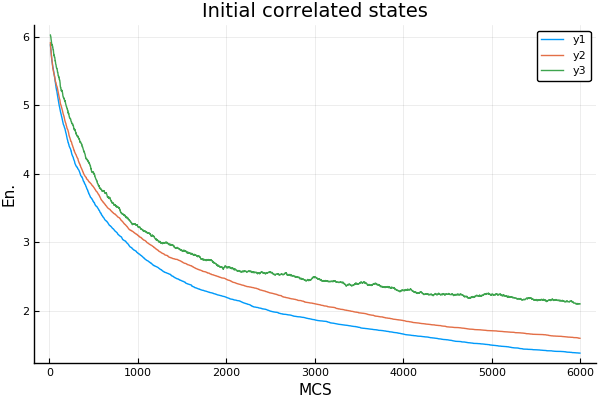

In [16]:
ψ₀_list = copy(ψ_list)
test_sim_list = copy(sim_list)
test_ψ_list = copy(ψ_list)
@show [E(test_ψ_list[i]) for i = 1:length(test_ψ_list)]
M_T = 6000
N = length(test_ψ_list[1].lattice)
test_ψ_list, E_matrix = @time nMCSEnergy!(test_ψ_list, test_sim_list, M_T, [E(ψ) for ψ in test_ψ_list]);
int = 11:M_T
@show [E(test_ψ_list[i]) for i = 1:length(test_ψ_list)]
@show [E_matrix[s,end] for s = 1:size(E_matrix,1)]
@show [E(ψ) for ψ in ψ_list]
flush(STDOUT)
display(plot(int, [E_matrix[s,int]/N for s = 1:size(E_matrix,1)]; xlabel="MCS", ylabel="En.", title="Initial correlated states"))

[E(ψ_list[i]) for i = 1:length(ψ_list)] = [10437.6, 10424.7, 10548.9]
 50.289642 seconds (124.99 M allocations: 4.492 GiB, 3.07% gc time)
[E(ψ_list[i]) for i = 1:length(ψ_list)] = [10202.0, 10379.3, 10048.3]
[E_matrix[s, end] for s = 1:size(E_matrix, 1)] = [-1.32209e5, -1.33876e5, -88469.3]
[E(ψ) for ψ = ψ_list] = [10202.0, 10379.3, 10048.3]


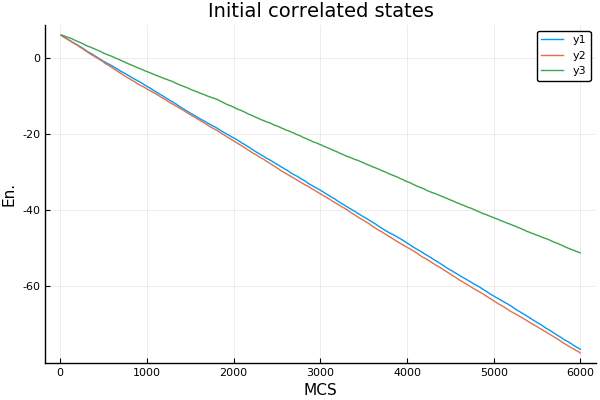

In [17]:
ψ₀_list = copy(ψ_list)
#sim_list = copy(sim_list)
#ψ_list = copy(ψ_list)
@show [E(ψ_list[i]) for i = 1:length(ψ_list)]
M_T = 6000
N = length(ψ_list[1].lattice)
ψ_list, E_matrix = @time nMCSEnergy!(ψ_list, sim_list, M_T, [E(ψ) for ψ in ψ_list]);
int = 11:M_T
@show [E(ψ_list[i]) for i = 1:length(ψ_list)]
@show [E_matrix[s,end] for s = 1:size(E_matrix,1)]
@show [E(ψ) for ψ in ψ_list]
flush(STDOUT)
display(plot(int, [E_matrix[s,int]/N for s = 1:size(E_matrix,1)]; xlabel="MCS", ylabel="En.", title="Initial correlated states"))

In [ ]:
adjustSimulationConstants